# GoingDeeper3-4 : 뉴스 카테고리 다중분류

1. Rubrics
    * 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
    * Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
    * 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.
    
2. 개요
    * 로이터 통신 데이터를 각각 5000개, 10000개, 20000개의 단어장을 가지고 따로 토큰화, 벡터화를 진행한다.
    * 이후 46개의 뉴스 카테고리 분류를 얼마나 정확도 있게 예측하는지 8가지의 머신러닝 기법을 적용해볼 것이다
    * 아래에서 사용할 머신러닝 기법은 다음과 같다.
        * 나이브 베이즈 분류기
        * Complement 베이즈 분류기
        * 로지스틱 회귀 모델
        * 서포트 벡터 머신
        * Decision Tree
        * Gradient Boosting
        * RandomForest
        * Voting
    * 원래는 딥러닝 모델과도 성능을 분석해야 했지만 3개의 단어장 크기별로 8개의 모델을 돌리는 과정에서 시간이 너무 많이 들어서 딥러닝 모델까지는 비교해보지 못했다.

# 1. 데이터 처리

## 1.1 필요한 모듈 import

In [6]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import os

from sklearn.feature_extraction.text import CountVectorizer # DTM 생성
from sklearn.feature_extraction.text import TfidfTransformer #TF-IDF 생성

from sklearn.naive_bayes import MultinomialNB, ComplementNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

## 1.2 필요 함수 정의

In [4]:
def decode_sequence(encoded_sequence):
    return [index_to_word[int_] for int_ in encoded_sequence]

def text_length(encoded_sequence):
    return len(encoded_sequence)

def make_sentence(decoded_sequence):
    return ' '.join(decoded_sequence)

def make_df(x_train, y_train, x_test, y_test):
    train = pd.DataFrame(data = {'encoded_sequence' : x_train, 'label' : y_train})
    test = pd.DataFrame(data = {'encoded_sequence' : x_test, 'label' : y_test})

    train['decoded_sequence'] = train['encoded_sequence'].apply(decode_sequence)
    train['length'] = train['encoded_sequence'].apply(text_length) 
    train['decoded_sequence'] = train['decoded_sequence'].apply(make_sentence)
    train = train[['encoded_sequence', 'decoded_sequence','length','label']]
    
    test['decoded_sequence'] = test['encoded_sequence'].apply(decode_sequence)
    test['length'] = test['encoded_sequence'].apply(text_length)
    test['decoded_sequence'] = test['decoded_sequence'].apply(make_sentence)
    test = test[['encoded_sequence', 'decoded_sequence','length','label']]
    
    return [train, test]

def convert_to_tfidfv(x_train, x_test):
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train['decoded_sequence'])
    x_test_dtm = dtmvector.transform(x_test['decoded_sequence'])
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)
    
    return [tfidfv, tfidfv_test]

def about_confusion_matrix(tfidfv_test, test, model):
    
    df_zeros = np.zeros((len(test)+1, len(model.classes_)))
    result = pd.DataFrame(df_zeros)
    result.columns = model.classes_
     
    for label in tqdm(model.classes_):
        predict_num = 0
        tp = 0
        fp = 0 
        tn = 0
        fn = 0
        for index_2, row in enumerate(tfidfv_test):
            if label == model.predict(row)[0]:
                predict_num += 1
                if label == test['label'][index_2]:
                    # P 예측 참
                    tp += 1

                else : 
                    # p 예측 거짓
                    fp += 1
            else:
                if label != test['label'][index_2]:
                    # n 예측 참
                    tn += 1
                else: 
                    # n 예측 거짓
                    fn += 1
            result[label][index_2] = {test['label'][index_2] : model.predict(row)[0]}
        result[label][index_2+1] = {"tp":tp,"fp":fp,"tn":tn,"fn":fn}
    
    return result

def accuracy_(result):
    return (result['tp'] + result['tn']) / (result['tp'] + result['tn'] + result['fp'] + result['fn'])

def precision_(result):
    if (result['tp'] + result['fp']) == 0: 
        return np.NaN
    else: 
        return (result['tp']) / (result['tp'] + result['fp'])

def recall_(result):
    if (result['tp'] + result['fn']) == 0 :
        return np.NaN
    else:
        return (result['tp']) / (result['tp'] + result['fn'])

def f_1_(result):
    if ((result['tp'] + result['fp']) == 0) or ((result['tp'] + result['fn']) == 0) or ((result['tp'] == 0)):
        return np.NaN
    else:
        precision = (result['tp']) / (result['tp'] + result['fp'])
        recall = (result['tp']) / (result['tp'] + result['fn'])
        return 2 * precision * recall / (precision + recall)
    
def confusion_matrix_processing(df):
    confusion_matrix_summary = pd.DataFrame(df.iloc[2246])
    confusion_matrix_summary = confusion_matrix_summary.rename(columns={2246 : 'matrix'})
    confusion_matrix_summary['accuracy'] = confusion_matrix_summary['matrix'].apply(accuracy_)
    confusion_matrix_summary['precision'] = confusion_matrix_summary['matrix'].apply(precision_)
    confusion_matrix_summary['recall'] = confusion_matrix_summary['matrix'].apply(recall_)
    confusion_matrix_summary['f1_score'] = confusion_matrix_summary['matrix'].apply(f_1_)

    return confusion_matrix_summary

def model_fit(md, tfidfv, tfidfv_test, train_df, test_df):
    model = md
    model.fit(tfidfv, train_df['label'])
    predicted = model.predict(tfidfv_test)
    confusion_matrix_model = about_confusion_matrix(tfidfv_test , test_df, model)
    confusion_matrix_summary = confusion_matrix_processing(confusion_matrix_model)
    
    return {"accuracy_score" : accuracy_score(test_df['label'], predicted),
             "classification_report" : classification_report(test_df['label'], model.predict(tfidfv_test)),
             "confusion_matrix_summary" : confusion_matrix_summary.to_dict()}

def get_accuracy (report):
    model_name = list(report.keys())
    vocab_size = list(report[model_name[0]].keys())
    result = {}
    for model in model_name:
        result[model] = []
        for size in vocab_size:
            result[model].append(report[model][size]['accuracy_score'])
    return result

## 1.3 단어장 별로 데이터 불러오기

1. data라는 dictionary 내부에 5000, 10000, 20000이란 key를 각각 설정하고 해당 value에 따로 로이터 뉴스 데이터를 불러온다.

2. 단어장은 pad, sos, unk 토큰이 들어갈 자리 3개를 마련해놓는다.
    
3. 뉴스 길이에 대한 분석을 진행하고 이를 시각화 한다.

In [3]:
data = {5000 : [] , 10000 : [], 20000 : [] }
data[5000] = reuters.load_data(num_words=5000, test_split=0.2)
data[10000] = reuters.load_data(num_words=10000, test_split=0.2)
data[20000] = reuters.load_data(num_words=20000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [4]:
word_to_index = reuters.get_word_index()
index_to_word = {index : word for word, index in word_to_index.items()}
index_to_word = {index + 3 : word for index, word in index_to_word.items()}
for index, token in enumerate(["<pad>","<sos>","<unk>"]):
    index_to_word[index] = token
index_to_word = dict(sorted(index_to_word.items()))
word_to_index = {word : index for index, word in index_to_word.items()}

565248/550378 [==============================] - 0s 0us/step


In [5]:
data_frame = {}
for (vocab, ((x_train, y_train),(x_test, y_test))) in data.items():
    data_frame[vocab] = make_df(x_train, y_train, x_test, y_test)

In [6]:
train_5000, test_5000 = data_frame[5000]
train_10000, test_10000 = data_frame[10000]
train_20000, test_20000 = data_frame[20000]

In [7]:
print("1.train 데이터 길이의 기본 통계량", train_5000['length'].describe(), sep = '\n'*2,end='\n'*5)
print("2.test 데이터 길이의 기본 통계량", test_5000['length'].describe(), sep = '\n'*2)

1.train 데이터 길이의 기본 통계량

count    8982.000000
mean      145.539857
std       145.822248
min        13.000000
25%        60.000000
50%        95.000000
75%       179.000000
max      2376.000000
Name: length, dtype: float64




2.test 데이터 길이의 기본 통계량

count    2246.000000
mean      147.661175
std       146.155744
min         2.000000
25%        60.000000
50%        95.000000
75%       183.000000
max      1032.000000
Name: length, dtype: float64


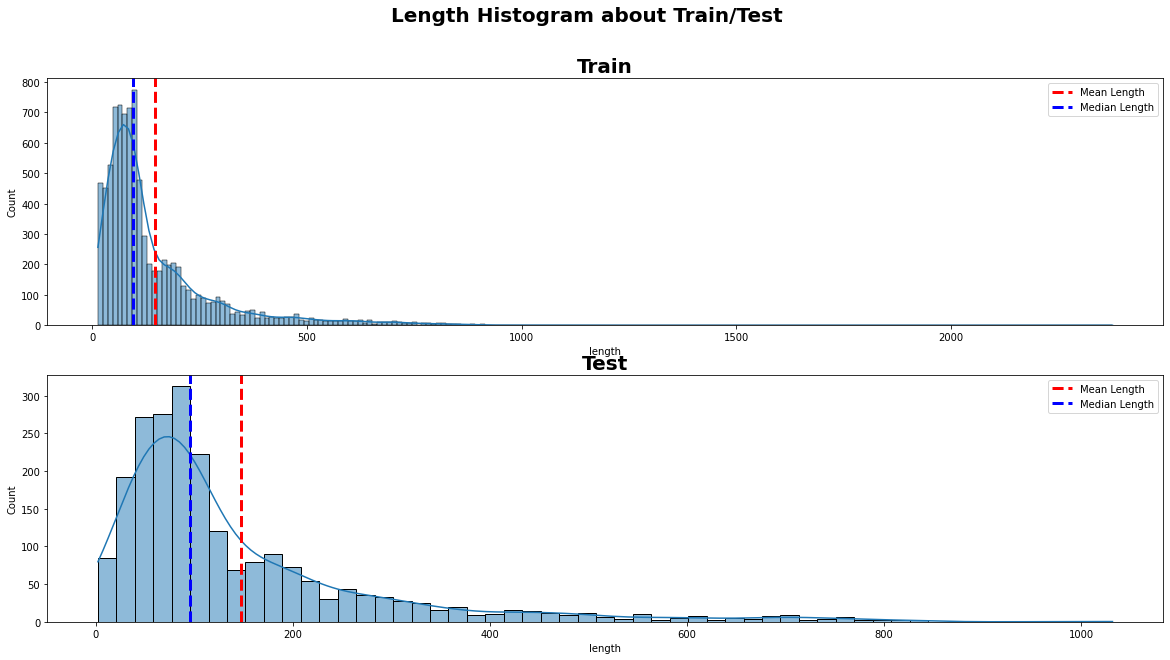

In [8]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Length Histogram about Train/Test', fontweight='bold', fontsize=20)

plt.subplot(2,1,1)
sns.histplot(train_5000, x='length', kde=True)
plt.axvline(train_5000['length'].mean(), c='red', lw=3, ls='--', label='Mean Length')
plt.axvline(train_5000['length'].median(), c='blue', lw=3, ls='--', label='Median Length')
plt.legend()
plt.title('Train',fontweight='bold', fontsize=20)

plt.subplot(2,1,2)
sns.histplot(test_5000, x='length', kde=True)
plt.axvline(test_5000['length'].mean(), c='red', lw=3, ls='--', label='Mean Length')
plt.axvline(test_5000['length'].median(), c='blue', lw=3, ls='--', label='Median Length')
plt.legend()
plt.title('Test',fontweight='bold', fontsize=20)

plt.show()

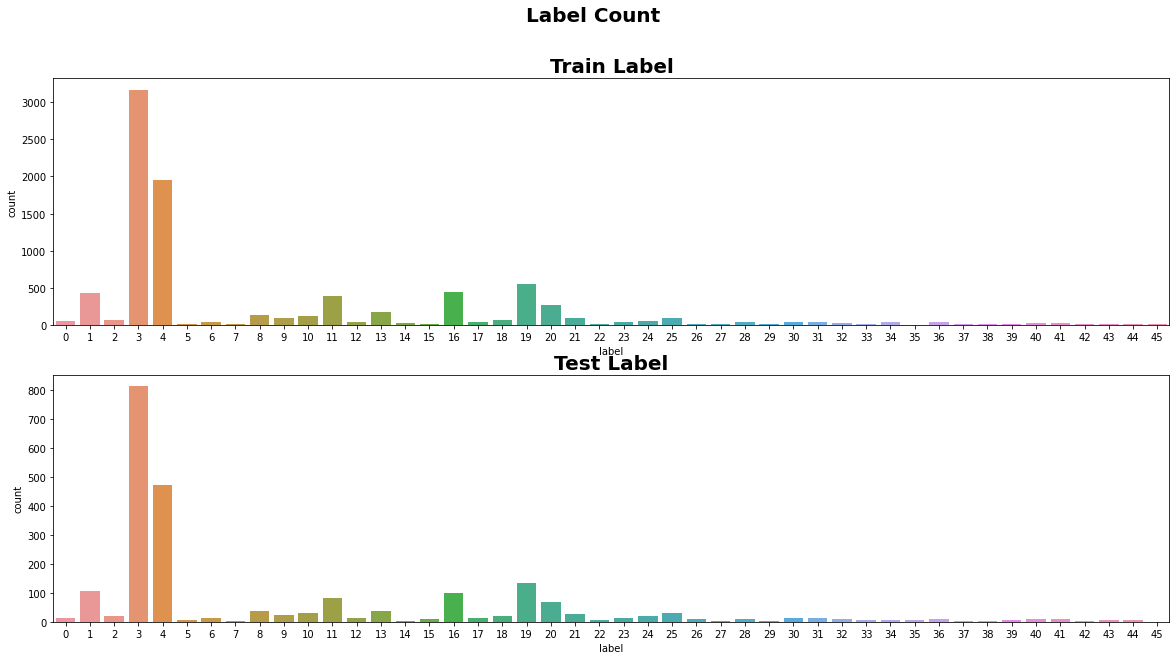

In [9]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Label Count", fontweight='bold', fontsize=20)

plt.subplot(2,1,1)
sns.countplot(x=train_5000['label'])
plt.title('Train Label',fontweight='bold', fontsize=20)

plt.subplot(2,1,2)
sns.countplot(x=test_5000['label'])
plt.title('Test Label',fontweight='bold', fontsize=20)
plt.show()

## 1.4 TF-IDF로 데이터 전처리

1. 토큰화 된 뉴스 기사를 빈도수 기반으로 벡터화를 진행한다.

In [10]:
TF_IDF = {}
TF_IDF[5000] = convert_to_tfidfv(train_5000, test_5000)
TF_IDF[10000] = convert_to_tfidfv(train_10000, test_10000)
TF_IDF[20000] = convert_to_tfidfv(train_20000, test_20000)
TF_IDF.keys()

dict_keys([5000, 10000, 20000])

# 2. 모델링

* 3개의 단어장 크기별로 8개의 모델을 돌리는 데 총 4시간 가까운 시간이 걸렸다.

In [11]:
params = {
    'nb' : {},
    'cb' : {},
    'lr' : {'C' : 10000, 'penalty' :'l2', 'max_iter' : 3000},
    'lsvc' : {'C' : 1000, 'penalty' : 'l1', 'max_iter' : 3000, 'dual' : False},
    'tree' : {'max_depth' : 10, 'random_state' : 0},
    'forest' : {'n_estimators' : 5, 'random_state' : 0},
    'grbt' : {'random_state' : 0},
    'vote' : {'estimators' : [('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
                              ('cb', ComplementNB()),
                              ('grbt', GradientBoostingClassifier(random_state=0))],
              'voting' : 'soft'}
}

models = [MultinomialNB(), 
          ComplementNB(), 
          LogisticRegression(C=params['lr']['C'], penalty=params['lr']['penalty'], max_iter=params['lr']['max_iter']), 
          LinearSVC(C=params['lsvc']['C'], penalty=params['lsvc']['penalty'], max_iter=params['lsvc']['max_iter'], dual=params['lsvc']['dual']),
          DecisionTreeClassifier(max_depth=params['tree']['max_depth'], random_state=params['tree']['random_state']),                
          RandomForestClassifier(n_estimators=params['forest']['n_estimators'], random_state=params['forest']['random_state']),
          GradientBoostingClassifier(random_state=params['grbt']['random_state']),
          VotingClassifier(estimators = params['vote']['estimators'], voting=params['vote']['voting'])]

In [12]:
report = {}
for model in tqdm(models):
    report[type(model).__name__] = {}
    for vocab, (tfidfv, tfidfv_test) in TF_IDF.items():
        report[type(model).__name__][vocab] = model_fit(model, tfidfv, tfidfv_test, data_frame[vocab][0], data_frame[vocab][1])

  2%|▏         | 1/46 [00:01<01:18,  1.74s/it]/tmp/ipykernel_32/407802230.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][index_2] = {test['label'][index_2] : model.predict(row)[0]}

100%|██████████| 46/46 [01:15<00:00,  1.64s/it]
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

100%|██████████| 46/46 [01:55<00:00,  2.52s/it]
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 1

100%|██████████| 46/46 [00:22<00:00,  2.03it/s]
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/pyth

100%|██████████| 46/46 [00:38<00:00,  1.18it/s]
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 1/

100%|██████████| 46/46 [02:40<00:00,  3.49s/it]

  2%|▏         | 1/46 [00:03<02:41,  3.60s/it]/tmp/ipykernel_32/407802230.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][index_2] = {test['label'][index_2] : model.predict(row)[0]}

100%|██████████| 46/46 [02:39<00:00,  3.47s/it]

  2%|▏         | 1/46 [00:03<02:36,  3.47s/it]/tmp/ipykernel_32/407802230.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[label][index_2] = {test['label'][index_2] : model.predict(row)[0]}

  2%|▏         | 1/46 [00:07<05:27,  7.28s/it]/tmp/ipykernel_32/407802230.py:65: SettingWithCopyWarning: 
A value is trying 

# 3. 결과 분석

In [13]:
report_path = os.path.join(os.getenv('HOME'), 'aiffel', 'aiffel','report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, ensure_ascii=False, indent=4)

In [7]:
report_path = os.path.join(os.getenv('HOME'), 'aiffel', 'aiffel','report.json')
with open(report_path, 'r') as f:
    Final_Report = json.load(f)
accuracy_report = get_accuracy(Final_Report)
accuracy_df = pd.DataFrame(data = accuracy_report, index = ['5000', '10000', '20000'])
accuracy_df = accuracy_df.apply(lambda x: (round(x, 3)))
accuracy_df.loc[3] = accuracy_df.sum(axis=0) / 3
accuracy_df.index = ['5000', '10000', '20000', 'Avg']
nb_200000_conf = pd.DataFrame(Final_Report['MultinomialNB']['20000']['confusion_matrix_summary'])
voting_20000_conf = pd.DataFrame(Final_Report['VotingClassifier']['20000']['confusion_matrix_summary'])

In [37]:
accuracy_df

,MultinomialNB,ComplementNB,LogisticRegression,LinearSVC,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
5000,0.673000,0.771000,0.804000,0.772000,0.618000,0.701,0.768,0.810000
10000,0.657000,0.771000,0.811000,0.787000,0.620000,0.674,0.766,0.817000
20000,0.619000,0.767000,0.816000,0.791000,0.621000,0.671,0.770,0.819000
Avg,0.649667,0.769667,0.810333,0.783333,0.619667,0.682,0.768,0.815333


In [36]:
accuracy_df.iloc[-1].sort_values(ascending = False)

VotingClassifier              0.815333
LogisticRegression            0.810333
LinearSVC                     0.783333
ComplementNB                  0.769667
GradientBoostingClassifier    0.768000
RandomForestClassifier        0.682000
MultinomialNB                 0.649667
DecisionTreeClassifier        0.619667
Name: Avg, dtype: float64

## 3.1 결과 분석_1 : accuracy 분석과 단어장 크기

1. 모델의 성능
   * 결정트리 -> 나이브베이즈 -> 랜덤포레스트 -> GradientBoosting -> 컴플리먼트 나이브 베이즈 -> Support Vector machine -> 로지스틱 회귀 -> 보팅 방식  
   * 가장 좋은 성능은 보팅 방식(81.5%) / 가장 나쁜 성능은 결정 트리(61.9%) 의정확성을 보여주고 있다.
   
2. 로지스틱 회귀와 보팅 방식이 비슷한 성능을 보여주는 것으로 보아 각 단어가 선형적인 종속 관계에 있음을 알 수 있다. 

3. 이는 나이브 베이즈 분류기의 성능이 낮은 것으로도 설명이 가능하다. 나이브 베이즈 분류기는 각 feature가 조건부 독립성을 유지할 때 좋은 성능을 발휘하는 것으로 알려져 있다. 

4. feature가 조건부 독립성을 유지하지 않기 때문에 나이브 베이즈 분류기의 성능이 낮다고 볼 수 있다. 

5. 나아가 단어 개수에 대한 유의미한 결과를 얻을 수 있었다. 성능이 나쁜 모델에선 단어 개수가 많아질수록 모델의 성능이 저하되는 것을 확인하였으나 성능이 좋은 모델에선 단어 개수가 많아질수록 정확도가 상승하는 것을 볼 수 있었다. 

In [40]:
nb_200000_conf

,matrix,accuracy,precision,recall,f1_score
0,"{'tp': 0, 'fp': 0, 'tn': 2234, 'fn': 12}",0.994657,NaN,0.000000,NaN
1,"{'tp': 41, 'fp': 11, 'tn': 2130, 'fn': 64}",0.966607,0.788462,0.390476,0.522293
2,"{'tp': 0, 'fp': 0, 'tn': 2226, 'fn': 20}",0.991095,NaN,0.000000,NaN
3,"{'tp': 745, 'fp': 251, 'tn': 1182, 'fn': 68}",0.857970,0.747992,0.916359,0.823659
4,"{'tp': 456, 'fp': 530, 'tn': 1242, 'fn': 18}",0.756011,0.462475,0.962025,0.624658
5,"{'tp': 0, 'fp': 0, 'tn': 2241, 'fn': 5}",0.997774,NaN,0.000000,NaN
6,"{'tp': 0, 'fp': 0, 'tn': 2232, 'fn': 14}",0.993767,NaN,0.000000,NaN
7,"{'tp': 0, 'fp': 0, 'tn': 2243, 'fn': 3}",0.998664,NaN,0.000000,NaN
8,"{'tp': 0, 'fp': 0, 'tn': 2208, 'fn': 38}",0.983081,NaN,0.000000,NaN
9,"{'tp': 1, 'fp': 0, 'tn': 2221, 'fn': 24}",0.989314,1.000000,0.040000,0.076923


In [39]:
voting_20000_conf

,matrix,accuracy,precision,recall,f1_score
0,"{'tp': 9, 'fp': 2, 'tn': 2232, 'fn': 3}",0.997774,0.818182,0.750000,0.782609
1,"{'tp': 80, 'fp': 23, 'tn': 2118, 'fn': 25}",0.978629,0.776699,0.761905,0.769231
2,"{'tp': 16, 'fp': 5, 'tn': 2221, 'fn': 4}",0.995993,0.761905,0.800000,0.780488
3,"{'tp': 760, 'fp': 69, 'tn': 1364, 'fn': 53}",0.945681,0.916767,0.934809,0.925700
4,"{'tp': 417, 'fp': 93, 'tn': 1679, 'fn': 57}",0.933215,0.817647,0.879747,0.847561
5,"{'tp': 1, 'fp': 0, 'tn': 2241, 'fn': 4}",0.998219,1.000000,0.200000,0.333333
6,"{'tp': 13, 'fp': 1, 'tn': 2231, 'fn': 1}",0.999110,0.928571,0.928571,0.928571
7,"{'tp': 1, 'fp': 0, 'tn': 2243, 'fn': 2}",0.999110,1.000000,0.333333,0.500000
8,"{'tp': 27, 'fp': 14, 'tn': 2194, 'fn': 11}",0.988869,0.658537,0.710526,0.683544
9,"{'tp': 20, 'fp': 4, 'tn': 2217, 'fn': 5}",0.995993,0.833333,0.800000,0.816327


## 3.2 결과 분석_2 : Confusion matrix 풀이

: 위는 가장 성능이 저조했던 nb_20000의 confusion matrix의 데이터프레임 버전과 가장 성능이 좋았던 voting_20000의 confusion matrix의 데이터프레임 버전이다.

: 정확도의 편차가 voting 쪽이 훨씬 작아서 안정적인 chart가 나오는 것을 확인할 수 있다. 반면 nb 쪽은 3,4라벨에 대한 정확도는 매우 낮게 형성되어 있다.

: NaN 값은 분모가 0이 되는 통계량을 의미한다.

: 0은 실제 값이 0인 통계량을 의미한다.

1. 데이터셋의 라벨이 대부분 3번과 4번으로 치우쳐 있는 상황이다. 이는 tfidfv의 단어장을 이루고 있는 9670개의 많은 단어가 라벨 3번과 4번에 기여하는 단어로 분포되어 있다는 뜻이다. 3번과 4번 라벨에 기여하는 단어는 빈번하게 등장하며 그 외에 라벨에 기여하는 단어는 희소하게 등장한다. 

</br>

2. 그러므로 데이터셋의 조건부 독립성이 보장되지 않는다. 예를 들어 3번 라벨과 15번 라벨에 기여하는 단어가 등장했을 때 8번 라벨에 기여하는 단어가 등장할 확률과 15번 라벨에 기여하는 단어가 등장했을 떄 8번 라벨에 기여하는 단어가 등장할 확률은 매우 다르다. 3번 라벨에 기여하는 단어는 매우 흔하기 때문에 그 중에서 8번 라벨에 기여하는 단어는 충분히 등장할 수 있다. 그러나 3번 라벨을 배제하는 순간 가정된 단어의 숫자가 너무 많이 줄어서 그 중에 8번 라벨에 기여하는 단어가 등장할 확률이 급감하게 된다.

</br>

3. 특정 라벨 기여 단어가 지나치게 많다면 이를 가정했을 때 희귀한 라벨 기여 단어가 등장할 확률과 이를 가정하지 않았을 떄 희귀한 라벨 기여 단어가 등장할 확률은 쉽게 달라질 수 있다. 분모가 충분히 크다면 분자의 값이 조금씩 흔들려도 그리 민감하게 반응하지 않지만 분모가 매우 작으면 분자의 값이 조금 흔들리는 것만으로 전체 값이 요동치는 것과 같은 이치이다.

</br>

4. 따라서 3번 라벨과 4번 라벨의 힘이 과대 대표되었다고 판단할 수 있으며 3번과 4번 라벨에 기여하는 단어들의 편향을 과도하게 학습했다고 볼 수 있다. 모델은 실제보다 훨씬 더 많은 비율로 3번과 4번을 예측하고 있다. recall은 실제 참인 것 중에 모델이 참이라고 예측한 것의 비율이다. 3번과 4번 모두 90% 전후의 recall을 기록하고 있다. 실제 3번 또는 4번인 것들에 대해 거의 빠뜨리지 않고 맞추고 있다. 

</br>

5. 이를 위해서 참이라고 외치지 말아야 할 것까지도 과도하게 많이 참이라고 외칠 수밖에 없다. 그 결과 모델이 참이라고 외친 횟수가 현격하게 치솟았으며 모델이 참이라고 외친 횟수 중 실제 참인 것의 비율은 낮아질 수밖에 없었다. 즉 precision에 비해 recall이 높은 것은 지나치게 3번 4번 라벨에 대한 단어를 열심히 학습한 탓이다. 

</br>

6. 대부분의 문장에 대해 3번 4번을 외치느라 정작 다른 라벨을 외칠 기회를 잃어버려서 다른 라벨의 recall율이 낮아져버렸다. 25번 라벨을 예시로 들면 총 31개의 데이터가 25번 라벨을 갖고 있으나 모델이 25번을 외친 경우는 고작 1번 밖에 되지 않았다. 나머지 30번에 대해선, 3번과 4번이라고 대답하느라 25번과 같은 희귀 라벨을 외치지 못한 것으로 풀이된다. 

</br>

7. 전체적인 정확도가 높게 나온 것 또한 3번과 4번에 대해 편중된 데이터 때문이다. 3번, 4번 라벨을 제외한 다른 라벨이 등장할 확률 자체가 희박하기 때문에 모델입장에선 희귀 라벨에 대해 아니다, 만 외쳐도 정확도가 올라가는 상황이 조성된 것이다. 

</br>

8. 이는 Complement Naive Bayes Classifier의 정확도가 훨씬 높았던 것으로도 설명이 된다. 컴플리먼트 나이브 베이즈 분류기는 클래스별로 훈련 데이터의 총합에서 해당 클래스의 샘플 수를 뺀 값을 가중치로 사용한다. 즉 빈도수가 적은 라벨은 적은 개수만 빠지니 가중치가 크게 잡히고 빈번한 라벨은 대부분의 데이터가 빠지니 가중치가 작게 잡힌다. 따라서 각 확률의 독립성을 확보할 수 있는 것이다.